# Sesión 8 - Implementación de algoritmos PPO

> En la presente sesión, se va a desarrollar la **implementación**  algoritmos avandos dentro de la familia de **Policy Gradients (PG)** En concreto, se va a implementar la versión básica de **Advantadge Actor-Critic (AC)** (sin multiproceso), y el algoritmo **Proximal Policy Optimization (PPO)**. La segunda versión incorpora ciertos avances con respecto al algoritmo PG. En concreto, trata de solventar el problema de la actualización de políticas incoherentes, a partir de la ponderación de los gradientes por un ratio de la evolución de la policy. La implementación será realizada utilizando la librería **pytorch**. Finalmente, se realizarán visualizaciones de KPIs del proceso de entrenamiento, con tal de analizar su convergencia, y su utilidad con respecto al PG básico

> En esta práctica se va a trabajar con el entorno de Atari Pong. Para más información, véase: https://www.gymlibrary.dev/environments/atari/pong/




---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.



---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```




---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/sesiones_practicas/sesion_practica_3"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

---
### 1.4. Instalar librerías necesarias


In [ ]:
if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
else:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0

---
## **PARTE 2** - **Funciones base**

Imports de librerías necesarias

In [ ]:
import os
import random
import gym
import pylab
import numpy as np
import torch
import cv2

Arquitectura de nuestro modelo y utilidades para trabajar con tensores

In [ ]:
class ActorCritic(torch.nn.Module):
    def __init__(self, n_actions):
        super(ActorCritic, self).__init__()
        self.conv1 = torch.nn.Conv2d(4, 32, 7, stride=4, padding="valid")
        self.conv2 = torch.nn.Conv2d(32, 64, 5, stride=2, padding="valid")
        self.conv3 = torch.nn.Conv2d(64, 64, 3, stride=1, padding="valid")

        self.fc1 = torch.nn.Linear(6 * 6 * 64, 512)
        torch.nn.init.kaiming_uniform_(self.fc1.weight)

        self.actor = torch.nn.Linear(512, n_actions)
        torch.nn.init.kaiming_uniform_(self.actor.weight)
        self.critic = torch.nn.Linear(512, 1)
        torch.nn.init.kaiming_uniform_(self.critic.weight)

    def forward(self, x):
        x = torch.nn.functional.elu(self.conv1(x))
        x = torch.nn.functional.elu(self.conv2(x))
        x = torch.nn.functional.elu(self.conv3(x))

        # print(x.shape)
        # Flatten:
        x = x.view(-1, 6 * 6 * 64)

        x = torch.nn.functional.elu(self.fc1(x))

        policy = self.actor(x)
        value = self.critic(x)

        return policy, value

def np_to_tensor(x):
    return torch.tensor(x).to(torch.float32)

---
## **PARTE 3** - **Actor-Critic (AC)**

---
### 3.1. A2C Pseudo-código

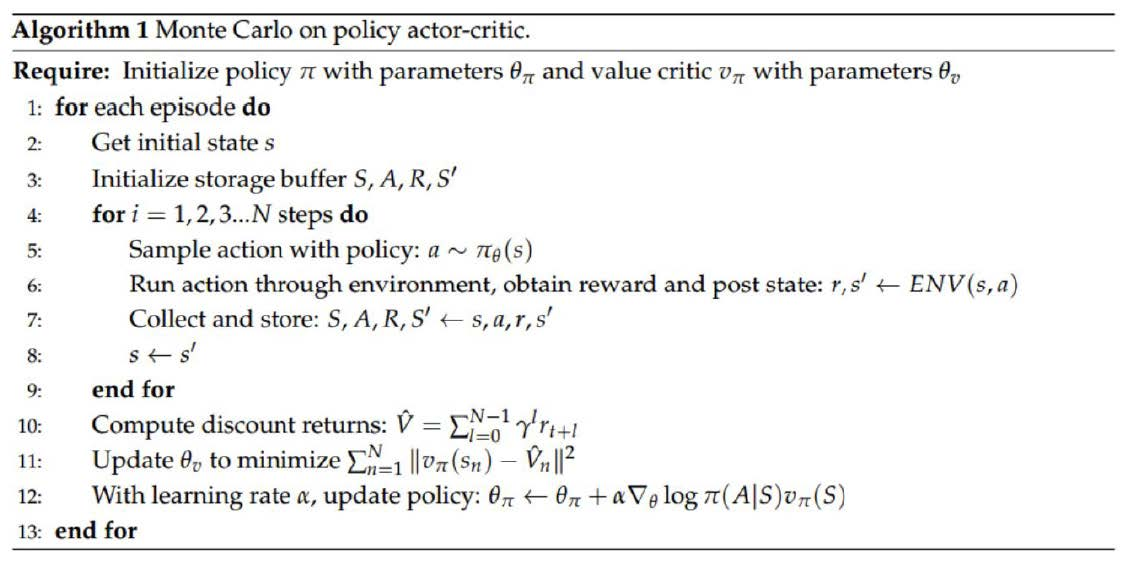

In [ ]:
from IPython import display
display.Image("images/mc-ac.jpg", width = 600, height = 400)

---
### 3.2. A2C Entrenamiento

Clase para el entrenamiento y testeo de un agente mediante A2C con un único proceso.

In [ ]:
class A2CAgent:
    # Algoritmo de optimización de A2C
    def __init__(self, env_name):
        # Initialization del entorno y parametros de A2C
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 10000, -21.0 # specific for pong
        self.lr = 0.000025
        self.bs = 32
        self.gamma = 0.99

        # Hyperparametros para pre-procesamiento obs -> state
        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Inicialización de la memoria
        self.states, self.actions, self.rewards, self.values = [], [], [], []
        self.scores, self.episodes, self.average = [], [], []

        # Preparar rutas de almacenamiento de estados y resultados
        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)

        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_A2C_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Crear el modelo
        self.model = ActorCritic(n_actions = self.action_size)
        # Preparar optimizador.
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)


    def remember(self, state, action, reward, value):
        # store episode actions to memory
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)
        self.values.append(value)

    def discount_rewards(self, reward):
        # Computamos los gamma-discounted rewards sobre un episodio
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reseteamos debido a re-inicio de partida (pong specific!)
                running_add = 0
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

        # Normalización para reducir la varianza
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return discounted_r

    def fit_actor(self, states, actions, advantages, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:,:,:])
            actions_batch = np_to_tensor(actions[indexes_batch,:].squeeze())
            advantages_batch = np_to_tensor(advantages[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            logits, _ = self.model(states_batch)

            # Obtenemos las probabilidades de la acción a partir de los logits
            log_softmax = torch.nn.functional.log_softmax(logits, -1)

            # Obtenemos criterios de optimización
            policy_loss = - torch.mean((log_softmax * actions_batch.detach()).sum(-1) * advantages_batch.detach())

            # Computamos gradientes
            policy_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += policy_loss.item()/(states.shape[0]//self.bs)

            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(policy_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    def fit_critic(self, states, discounted_r, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:,:,:])
            discounted_r_batch = np_to_tensor(discounted_r[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            _, values = self.model(states_batch)

            # Obtenemos criterios de optimización
            critic_loss = torch.mean((discounted_r_batch.detach() - values).pow(2))

            # Computamos gradientes
            critic_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += critic_loss.item()/(states.shape[0]//self.bs)
            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(critic_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    def replay(self):
        # Pasamos la memoria de listas a arrays
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)
        values = np.array(self.values)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Compute advantages
        advantages = discounted_r - values

        # training Actor and Critic networks
        self.fit_actor(states, actions, advantages)
        self.fit_critic(states, discounted_r)

        # reset training memory
        self.states, self.actions, self.rewards, self.values = [], [], [], []

    def load(self, model_name):
        self.model.load_state_dict(torch.load(model_name))

    def save(self):
        torch.save(self.model.state_dict(), self.Model_name + '.pth')

    # Función para visualizar la evolución del entrenamiento
    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    # Función de pre-procesamiento observación --> estado
    def GetImage(self, frame):
        # Cropeamos la información de la imagen
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)

        # Convertimos a rgb
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # Convertimos a máscara binaria para acelerar el entrenamiento
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255

        # Normalizamos los valroes de intensidad
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        return np.expand_dims(self.image_memory, axis=0)

    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info

    def run(self):
        # Bucle de episodios de entrenamiento
        for e in range(self.EPISODES):
            self.model.eval()
            state = self.reset()
            done, score, SAVING = False, 0, ''
            # Bucle para recopilar la trayectoria
            while not done:
                # Elección de acción por parte del actor
                action, value = self.model(np_to_tensor(state))
                # Pasamos a distribución de probabilidad
                action_prob = torch.softmax(action, -1).squeeze().detach().numpy()
                # Hacemos un sampling de la acción - exploraicón
                action = np.random.choice(self.action_size, p=action_prob)
                value = value.squeeze().detach().numpy()
                # Dada la acción seleccionado, interaccionar con el entorno y recibir nuevo estado y recompensa
                next_state, reward, done, _ = self.step(action)
                # Almacenamiento de memoria para posterior entrenamiento
                self.remember(state, action, reward, value)
                # Update current state
                state = next_state
                score += reward

                if done: # Estado terminal
                    # Al acabar la trayectoria, almacenamos KPIs para curva de entrenamiento y almacenamos mejor modelo
                    average = self.PlotModel(score, e)
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    # Entrenamos un modelo haciendo un replay de la trayectoria
                    self.replay()

        # close enviroment when finish training
        self.env.close()

    # Función de testeo
    def test(self, Actor_name, Critic_name):
        self.load(model_name)
        self.model.eval()

        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                # Al testear, seleccionamos la acción con mayor probabilidad (no muestreo)
                action, value = self.model(np_to_tensor(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

if __name__ == "__main__":
    env_name = 'PongDeterministic-v4'
    agent = A2CAgent(env_name)
    agent.run()


---
## **PARTE 4** - **Proximal Policy Optimization (PPO)**


---
### 4.1. PPO Pseudo-código

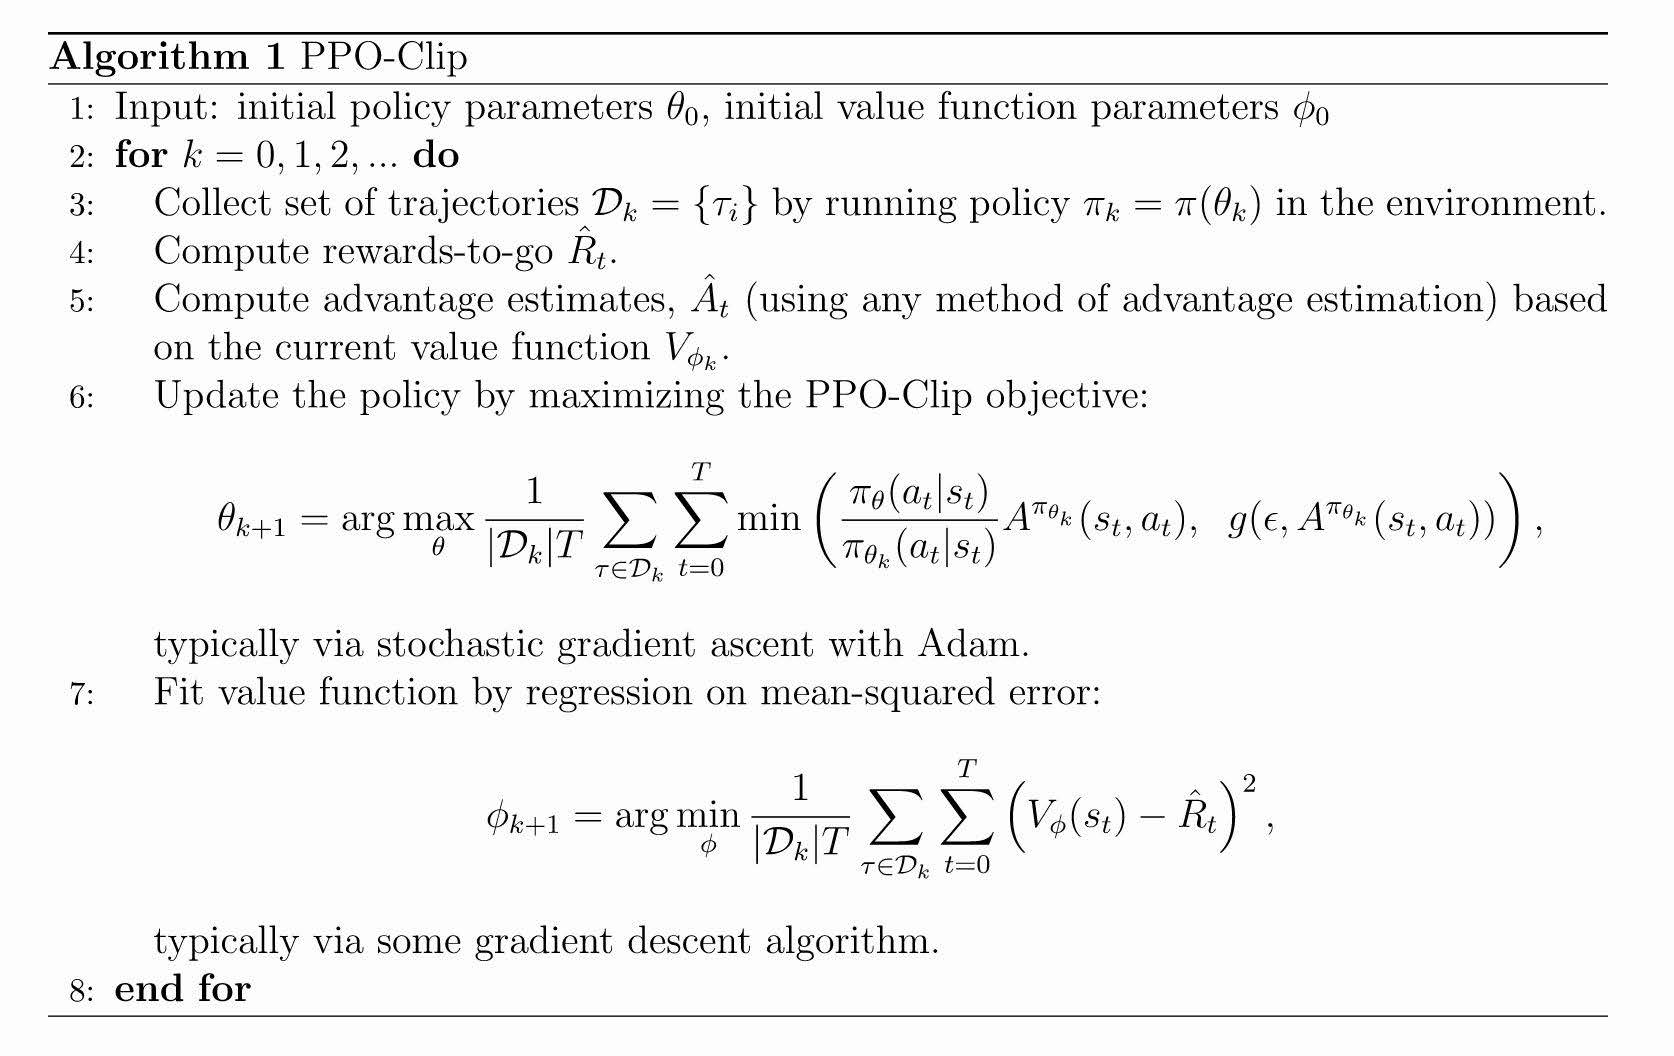

In [ ]:
from IPython import display
display.Image("images/ppo.jpg", width = 600, height = 400)

---
### 4.2. PPO Entrenamiento

Clase para el entrenamiento y testeo de un agente mediante PPO con un único proceso.

In [ ]:
class PPOAgent:
    # Algoritmo de optimización de PPO
    def __init__(self, env_name):
        # Initialization del entorno y parametros de PPO
        self.env_name = env_name
        self.env = gym.make(env_name)
        self.action_size = self.env.action_space.n
        self.EPISODES, self.max_average = 1000, -21.0 # specific for pong
        self.lr = 0.0001
        self.bs = 32
        self.gamma = 0.99

        # Hyperparametros para pre-procesamiento obs -> state
        self.ROWS = 80
        self.COLS = 80
        self.REM_STEP = 4

        # Hyperparametros propios de PPO
        self.LOSS_CLIPPING = 0.2
        self.ENTROPY_LOSS = 5e-3
        self.epochs = 10

        # Inicialización de la memoria
        self.states, self.actions, self.rewards, self.values, self.actions_probs = [], [], [], [], []
        self.scores, self.episodes, self.average = [], [], []

        # Preparar rutas de almacenamiento de estados y resultados
        self.Save_Path = 'Models'
        self.state_size = (self.REM_STEP, self.ROWS, self.COLS)
        self.image_memory = np.zeros(self.state_size)

        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.path = '{}_PPO_{}'.format(self.env_name, self.lr)
        self.Model_name = os.path.join(self.Save_Path, self.path)

        # Crear el modelo
        self.model = ActorCritic(n_actions = self.action_size)
        # Preparar optimizador.
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)


    def remember(self, state, action, reward, value, action_prob):
        # Almacenamiento de todas las variables que definen una transición para PPO
        self.states.append(state)
        action_onehot = np.zeros([self.action_size])
        action_onehot[action] = 1
        self.actions.append(action_onehot)
        self.rewards.append(reward)
        self.values.append(value)
        self.actions_probs.append(action_prob)

    def discount_rewards(self, reward):
        # Computamos los gamma-discounted rewards sobre un episodio
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            if reward[i] != 0: # reseteamos debido a re-inicio de partida (pong specific!)
                running_add = 0
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

        # Normalización para reducir la varianza
        discounted_r -= np.mean(discounted_r)
        discounted_r /= np.std(discounted_r)
        return discounted_r

    def fit_actor(self, states, actions, advantages, actions_probs, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:,:,:])
            actions_batch = np_to_tensor(actions[indexes_batch,:].squeeze())
            advantages_batch = np_to_tensor(advantages[indexes_batch])
            actions_probs_batch = np_to_tensor(actions_probs[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            logits, _ = self.model(states_batch)

            # Obtenemos las probabilidades de la acción a partir de los logits
            prob = torch.nn.functional.softmax(logits, -1)

            # Seleccionamos probabilidad de acción realizada y antigua
            prob = torch.sum(prob * actions_batch, -1)
            old_prob = torch.sum(actions_probs_batch * actions_batch, -1)

            # Calculamos el ratio
            r = prob/(old_prob + 1e-10)

            # Ponderación por función ventaja
            p1 = r * advantages_batch

            # Clip
            p2 = torch.clip(r, min=1 - self.LOSS_CLIPPING, max=1 + self.LOSS_CLIPPING) * advantages_batch

            # Calculate loss
            ppo_loss = -torch.mean(torch.minimum(p1, p2) + self.ENTROPY_LOSS * -(prob * torch.log(prob + 1e-10)))

            # Computamos gradientes
            ppo_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += ppo_loss.item()/(states.shape[0]//self.bs)

            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(ppo_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    def fit_critic(self, states, discounted_r, verbose=False):
        self.model.train()

        idx, track_loss = 0, 0
        indexes = np.arange(0, states.shape[0])
        np.random.shuffle(indexes)
        for i_epoch in range(states.shape[0]//self.bs):
            indexes_batch = indexes[idx:idx+self.bs]

            # Seleccionamos un batch de la trayectoria
            states_batch = np_to_tensor(states[indexes_batch,:,:,:])
            discounted_r_batch = np_to_tensor(discounted_r[indexes_batch])

            # Hacemos forward al actor-critic dado el estado actual
            _, values = self.model(states_batch)

            # Obtenemos criterios de optimización
            critic_loss = torch.mean((discounted_r_batch.detach() - values).pow(2))

            # Computamos gradientes
            critic_loss.backward()
            # Actualizamos los pesos
            self.optimizer.step()
            # Limpiamos gradientes del modelo
            self.optimizer.zero_grad()
            # Actualizamos iterador de batch
            idx += self.bs
            track_loss += critic_loss.item()/(states.shape[0]//self.bs)
            if verbose:
                print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(critic_loss.item()), end="\r")
        if verbose:
            print(str(i_epoch) + "/" + str(states.shape[0]//self.bs) + " - loss: " + str(track_loss), end="\n")

        self.model.eval()

    # Función principal de entrenamiento
    def replay(self):
        # Pasamos la memoria de listas a arrays
        states = np.vstack(self.states)
        actions = np.vstack(self.actions)
        values = np.array(self.values)
        actions_probs = np.array(self.actions_probs)

        # Compute discounted rewards
        discounted_r = self.discount_rewards(self.rewards)

        # Compute advantages
        advantages = discounted_r - values

        # Training Actor and Critic networks
        for _ in range(self.epochs):
            self.fit_actor(states, actions, advantages, actions_probs)
        for _ in range(self.epochs):
            self.fit_critic(states, discounted_r)

        # reset training memory
        self.states, self.actions, self.rewards, self.values, self.actions_probs = [], [], [], [], []

    def load(self, model_name):
        self.model.load_state_dict(torch.load(model_name))

    def save(self):
        torch.save(self.model.state_dict(), self.Model_name + '.pth')

    # Función para visualizar la evolución del entrenamiento
    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes, self.scores, 'b')
            pylab.plot(self.episodes, self.average, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.savefig(self.path+".png")
            except OSError:
                pass

        return self.average[-1]

    # Función de pre-procesamiento observación --> estado
    def GetImage(self, frame):
        # Cropeamos la información de la imagen
        frame_cropped = frame[35:195:2, ::2,:]
        if frame_cropped.shape[0] != self.COLS or frame_cropped.shape[1] != self.ROWS:
            # OpenCV resize function
            frame_cropped = cv2.resize(frame, (self.COLS, self.ROWS), interpolation=cv2.INTER_CUBIC)

        # Convertimos a rgb
        frame_rgb = 0.299*frame_cropped[:,:,0] + 0.587*frame_cropped[:,:,1] + 0.114*frame_cropped[:,:,2]

        # Convertimos a máscara binaria para acelerar el entrenamiento
        frame_rgb[frame_rgb < 100] = 0
        frame_rgb[frame_rgb >= 100] = 255

        # Normalizamos los valroes de intensidad
        new_frame = np.array(frame_rgb).astype(np.float32) / 255.0

        # push our data by 1 frame, similar as deq() function work
        self.image_memory = np.roll(self.image_memory, 1, axis = 0)

        # inserting new frame to free space
        self.image_memory[0,:,:] = new_frame

        return np.expand_dims(self.image_memory, axis=0)

    # Función para resetear el entorno tras acabar trayectoria
    def reset(self):
        frame = self.env.reset()
        for i in range(self.REM_STEP):
            state = self.GetImage(frame)
        return state

    # Función para interacción agente-entorno
    def step(self, action):
        next_state, reward, done, info = self.env.step(action)
        next_state = self.GetImage(next_state)
        return next_state, reward, done, info

    # Función principal de exploración + entrenamiento
    def run(self):
        # Bucle de episodios de entrenamiento
        for e in range(self.EPISODES):
            self.model.eval()
            state = self.reset()
            done, score, SAVING = False, 0, ''
            # Bucle para recopilar la trayectoria
            while not done:
                # Elección de acción por parte del actor
                action, value = self.model(np_to_tensor(state))
                # Pasamos a distribución de probabilidad
                action_prob = torch.softmax(action, -1).squeeze().detach().numpy()
                # Hacemos un sampling de la acción - exploraicón
                action = np.random.choice(self.action_size, p=action_prob)
                value = value.squeeze().detach().numpy()
                # Dada la acción seleccionado, interaccionar con el entorno y recibir nuevo estado y recompensa
                next_state, reward, done, _ = self.step(action)
                # Almacenamiento de memoria para posterior entrenamiento
                self.remember(state, action, reward, value, action_prob)
                # Update current state
                state = next_state
                score += reward

                if done: # Estado terminal
                    # Al acabar la trayectoria, almacenamos KPIs para curva de entrenamiento y almacenamos mejor modelo
                    average = self.PlotModel(score, e)
                    if average >= self.max_average:
                        self.max_average = average
                        self.save()
                        SAVING = "SAVING"
                    else:
                        SAVING = ""
                    print("episode: {}/{}, score: {}, average: {:.2f} {}".format(e, self.EPISODES, score, average, SAVING))

                    # Entrenamos un modelo haciendo un replay de la trayectoria
                    self.replay()

        # close environemnt when finish training
        self.env.close()

    # Función de testeo
    def test(self, Actor_name, Critic_name):
        self.load(model_name)
        self.model.eval()

        for e in range(100):
            state = self.reset()
            done = False
            score = 0
            while not done:
                # Al testear, seleccionamos la acción con mayor probabilidad (no muestreo)
                action, value = self.model(np_to_tensor(state))
                state, reward, done, _ = self.step(action)
                score += reward
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, score))
                    break
        self.env.close()

if __name__ == "__main__":
    env_name = 'PongDeterministic-v4'
    agent = PPOAgent(env_name)
    agent.run()

---
## **PARTE 5** - **Comparación de soluciones**

In [ ]:
from IPython import display
display.Image("images/a2c_lc.png", width = 600, height = 400)

In [ ]:
from IPython import display
display.Image("images/ppo_lc.png", width = 600, height = 400)

---